In [30]:
import nltk
import random
from nltk.corpus import movie_reviews as mr
from sklearn.feature_extraction.text import CountVectorizer

Mirar como es el fichero:

In [31]:
print(len(mr.fileids()) )#hay 2000 ficheros (1000 exemples positius i 1000 negatius)
print(mr.words('pos/cv000_29590.txt'))
print(mr.categories())
print(mr.fileids('pos')) #lista todos los ficheros positivos
print((list(mr.words('pos/cv000_29590.txt')), 'pos') )

2000
['films', 'adapted', 'from', 'comic', 'books', 'have', ...]
['neg', 'pos']
['pos/cv000_29590.txt', 'pos/cv001_18431.txt', 'pos/cv002_15918.txt', 'pos/cv003_11664.txt', 'pos/cv004_11636.txt', 'pos/cv005_29443.txt', 'pos/cv006_15448.txt', 'pos/cv007_4968.txt', 'pos/cv008_29435.txt', 'pos/cv009_29592.txt', 'pos/cv010_29198.txt', 'pos/cv011_12166.txt', 'pos/cv012_29576.txt', 'pos/cv013_10159.txt', 'pos/cv014_13924.txt', 'pos/cv015_29439.txt', 'pos/cv016_4659.txt', 'pos/cv017_22464.txt', 'pos/cv018_20137.txt', 'pos/cv019_14482.txt', 'pos/cv020_8825.txt', 'pos/cv021_15838.txt', 'pos/cv022_12864.txt', 'pos/cv023_12672.txt', 'pos/cv024_6778.txt', 'pos/cv025_3108.txt', 'pos/cv026_29325.txt', 'pos/cv027_25219.txt', 'pos/cv028_26746.txt', 'pos/cv029_18643.txt', 'pos/cv030_21593.txt', 'pos/cv031_18452.txt', 'pos/cv032_22550.txt', 'pos/cv033_24444.txt', 'pos/cv034_29647.txt', 'pos/cv035_3954.txt', 'pos/cv036_16831.txt', 'pos/cv037_18510.txt', 'pos/cv038_9749.txt', 'pos/cv039_6170.txt', 'pos/cv

# Particion Train y Test:

In [32]:
doc_pos = [mr.words(f) for f in mr.fileids('pos')]
doc_neg = [mr.words(f) for f in mr.fileids('neg')]

In [33]:
random.shuffle(doc_pos)
random.shuffle(doc_neg)

In [34]:
train_pos = doc_pos[:int((len(doc_pos)*0.7))] #70% para el train
test_pos = doc_pos[int((len(doc_pos)*0.7)):] #30% final para el test

train_neg = doc_neg[:int((len(doc_neg)*0.7))]
test_neg = doc_neg[int((len(doc_neg)*0.7)):]

In [35]:
train = train_pos + train_neg
test = test_pos + test_neg
#hay que guardar estos ficheros porque cada vez que ejecutemos el codigo el random va a cambiar el contenido

In [36]:
print(len(train_pos), len(train_neg))
print(len(test_pos), len(test_neg))

700 700
300 300


In [37]:
train[699] in train_pos

True

In [38]:
train_labels = [1]*700 + [0]*700
print(len(train_labels))
test_labels = [1]*300 + [0]*300

1400


# Preprocesamiento

In [39]:
import re

def preproces(text):
    text_clean = []
    # Expresión regular para eliminar todo lo que no sea una letra o un espacio
    regex = r"[^a-zA-Z\s]"
    
    # Diccionario de reemplazo
    replacements = {
        "t": "not",
        's': 'is', #aunque tambien puede ser posesivo
        "didn": "did",
        "haven": "have",
        "hasn": "has",
        "hadn": "had",
        "shouldn": "should",
        "wouldn": "would",
        "couldn": "could",
        "mustn": "must",
        'doesn': 'does',
        'isn' : 'is',
        'aren' : 'are',
        'll': 'will',
        've' : 'have', 
        'd' : 'would',
        'm': 'am'
    }
    
    for w in text:
        # Eliminar caracteres no deseados y números
        limpio = re.sub(regex, "", w)
        # Convertir a minúsculas
        limpio = limpio.lower()
        # Eliminar espacios en blanco al principio y al final
        limpio = limpio.strip()
        # Eliminar si la palabra es "s"
        #if limpio == "s":
           # continue
        # Reemplazar si está en el diccionario
        if limpio in replacements:
            limpio = replacements[limpio]
        # Filtrar tokens vacíos
        if limpio != "":
            text_clean.append(limpio)
    
    return text_clean

In [40]:
clean_train = [preproces(words) for words in train]
print(clean_train[0])
clean_test = [preproces(words)for words in test]

['plot', 'a', 'peculiar', 'french', 'girl', 'grows', 'up', 'lonely', 'with', 'her', 'father', 'and', 'does', 'not', 'quite', 'know', 'what', 'she', 'wants', 'out', 'of', 'life', 'one', 'day', 'she', 'falls', 'upon', 'something', 'and', 'believes', 'that', 'her', 'ticket', 'to', 'happiness', 'may', 'be', 'in', 'helping', 'others', 'she', 'starts', 'with', 'the', 'people', 'around', 'her', 'but', 'when', 'she', 'suddenly', 'falls', 'for', 'her', 'own', 'guy', 'she', 'can', 'not', 'act', 'strongly', 'enough', 'because', 'of', 'her', 'shy', 'and', 'dreamy', 'nature', 'critique', 'a', 'clever', 'quirky', 'original', 'french', 'flick', 'set', 'in', 'a', 'picturesque', 'paris', 'featuring', 'an', 'endearing', 'lead', 'with', 'a', 'giant', 'imagination', 'much', 'loneliness', 'and', 'a', 'little', 'bit', 'of', 'love', 'for', 'everyone', 'this', 'is', 'a', 'feel', 'good', 'kind', 'of', 'movie', 'a', 'fairy', 'tale', 'for', 'grown', 'ups', 'who', 'are', 'bummed', 'out', 'about', 'life', 'it', 'd

# Lematizacion

In [41]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jiahu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [42]:
#Poner tags y no incluir stop Words ya que no aportaran informacion importante para el Sentiment Analisys
train_tagged = []
tags = set()
stop_tags = {'DT', 'IN', 'CC', 'PRP', 'PRP$', 'WP', 'WP$', 'RP', 'TO', 'CD', 'EX', 'WDT'}
for l in clean_train:
    aux = []
    con_tag = nltk.pos_tag(l)
    for w, tag in con_tag:
        if tag not in stop_tags:
            aux.append((w, tag))
            tags.add(tag)
    train_tagged.append(aux)

In [43]:
print(tags) #todos los tags unicos que aparecen en el train

{'VBG', 'RBS', 'VBD', 'SYM', 'VBP', 'RB', 'POS', 'JJS', 'WRB', 'JJ', 'NN', 'UH', 'VBN', 'JJR', 'MD', 'RBR', 'PDT', 'FW', 'VB', '$', 'NNS', 'VBZ', 'NNP', 'NNPS'}


In [44]:
#ejemplo del resultado
print(train_tagged[0])
print(train[0]) 

[('plot', 'NN'), ('peculiar', 'JJ'), ('french', 'JJ'), ('girl', 'NN'), ('grows', 'VBZ'), ('lonely', 'RB'), ('father', 'NN'), ('does', 'VBZ'), ('not', 'RB'), ('quite', 'RB'), ('know', 'VB'), ('wants', 'VBZ'), ('life', 'NN'), ('day', 'NN'), ('falls', 'VBZ'), ('something', 'NN'), ('believes', 'VBZ'), ('ticket', 'NN'), ('happiness', 'VB'), ('may', 'MD'), ('be', 'VB'), ('helping', 'VBG'), ('others', 'NNS'), ('starts', 'VBZ'), ('people', 'NNS'), ('when', 'WRB'), ('suddenly', 'RB'), ('falls', 'VBZ'), ('own', 'JJ'), ('guy', 'NN'), ('can', 'MD'), ('not', 'RB'), ('act', 'VB'), ('strongly', 'RB'), ('enough', 'RB'), ('shy', 'NN'), ('dreamy', 'JJ'), ('nature', 'NN'), ('critique', 'NN'), ('clever', 'NN'), ('quirky', 'JJ'), ('original', 'JJ'), ('french', 'JJ'), ('flick', 'NN'), ('set', 'VBN'), ('picturesque', 'JJ'), ('paris', 'NN'), ('featuring', 'VBG'), ('endearing', 'VBG'), ('lead', 'NN'), ('giant', 'JJ'), ('imagination', 'NN'), ('much', 'JJ'), ('loneliness', 'NN'), ('little', 'JJ'), ('bit', 'NN'),

In [45]:
#ver otros ejemplos de palabras con un cierto tag
palabras = []
for l in train_tagged:
    for palabra, etiqueta in l:
            if etiqueta == '$':
                palabras.append(palabra)
print(palabras)

['lambs', 'ten']


El tag '$' es un error del tagger pero no upondrá ningún problema. Además, al observar el tag "FW" (palabras que se etiquetan como extranjeras) vemos que podríamos eliminar errores, palabras en otros idiomas, nombres propios, pero también palabras normales. Como posteriormnte se va a hacer filtrado de frequencias esperamos que se eliminarán las palabras no deseadas y quedarán las que sí que tienen sentido.

Se lematizan solo estas categorias, reconocidas por SentiWordNet:

Sustantivos ('n')	'NN', 'NNS', 'NNP', 'NNPS'
Verbos ('v')	'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
Adjetivos ('a')	'JJ', 'JJR', 'JJS'
Adverbios ('r')	'RB', 'RBR', 'RBS'

In [46]:
nltk.download('wordnet')
nltk.download('omw-1.4')
wnl = nltk.stem.WordNetLemmatizer()
def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n', 'NNP' : 'n', 'NNPS':'n',
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 'MD':'v',
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'} 
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  return p[0]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jiahu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jiahu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [47]:
train_lemat = []
for l in train_tagged:
    aux = []
    for i in l:
        aux.append(lemmatize(i))
    train_lemat.append(aux)

## Vectroización BoW

In [48]:
vectorizer = CountVectorizer()
train_aplanado = [' '.join(sublista) for sublista in train_lemat]
X_train = vectorizer.fit_transform(train_aplanado)

In [ ]:
X_train.shape

(1400, 27607)

In [60]:
train_aplanado[1]

'david mamet have long be favorite screenwriter director distinctive more often not ingenious dialogue laid back style direction nearly movie be absolutely irresistible tend be thickly layer deceptive production require audience look film less superficial manner plot seem require order discern concealed message sometimes even concealed storyline real plot new project winslow boy be slightly more conspicuous other endeavor be still brilliantly complex consistently rivet motion picture honor sacrifice difference be commonly know justice be right oh be rat g incidentally be first time mamet have decide adapt someone else be work namely play terrence rattigan set th century cast nigel hawthorne lead role arthur rich age man find year old son ronnie have be kick naval academy allegedly steal shilling postal note do do ask boy father i do not ronnie answer be enough arthur old daughter rebecca pidgeon immediately start crusade bring son be case court enlist help sir robert morton notorious a

Eliminacion de frequencias bajas

In [50]:
# Sumamos las frecuencias de cada palabra en todos los documentos
word_frequencies = X_train.sum(axis=0).A1
# Obtenemos el vocabulario mapeado a índices
words = vectorizer.get_feature_names_out()
# Convertimos en un diccionario {palabra: frecuencia}
freq_dict = dict(zip(words, word_frequencies))
# Ordenamos por frecuencia ascendente
sorted_freq = sorted(freq_dict.items(), key=lambda x: x[1])
print(sorted_freq[:10])  # Muestra las 10 palabras menos frecuentes


[('aa', np.int64(1)), ('aaa', np.int64(1)), ('aaaahhhs', np.int64(1)), ('aamir', np.int64(1)), ('aardman', np.int64(1)), ('abberation', np.int64(1)), ('abbott', np.int64(1)), ('abbotts', np.int64(1)), ('abbreviated', np.int64(1)), ('abdomen', np.int64(1))]


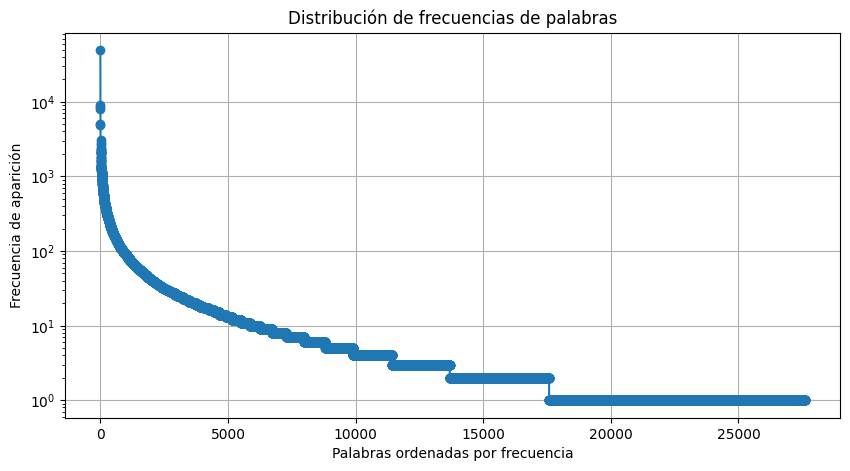

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Ordenamos las frecuencias en orden descendente
sorted_freq_values = np.array(sorted(word_frequencies, reverse=True))

# Creamos la gráfica
plt.figure(figsize=(10,5))
plt.plot(sorted_freq_values, marker="o", linestyle="-")

# Agregamos etiquetas
plt.xlabel("Palabras ordenadas por frecuencia")
plt.ylabel("Frecuencia de aparición")
plt.title("Distribución de frecuencias de palabras")
plt.yscale("log") 
plt.grid()

In [52]:
min_freq = 3  # Umbral mínimo (si se pone mas agrande se eliminaran mas de la mitad de las observaciones)
vectorizer = CountVectorizer(min_df=min_freq)
X_filtered = vectorizer.fit_transform(train_aplanado)

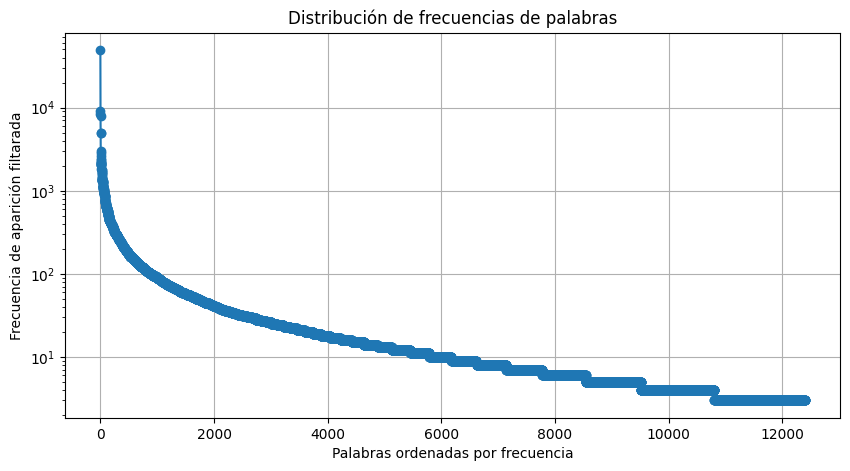

In [53]:
word_frequencies = X_filtered.sum(axis=0).A1
sorted_freq_values = np.array(sorted(word_frequencies, reverse=True))

# Creamos la gráfica
plt.figure(figsize=(10,5))
plt.plot(sorted_freq_values, marker="o", linestyle="-")

# Agregamos etiquetas
plt.xlabel("Palabras ordenadas por frecuencia")
plt.ylabel("Frecuencia de aparición filtarada")
plt.title("Distribución de frecuencias de palabras")
plt.yscale("log") 
plt.grid()

In [54]:
X_filtered.shape #train final

(1400, 12399)

# Modelos supervisados. Parte 1:

Una vez que ya tengamos los datos preprocesados de manera que faciliten a los modelos a classificar los documentos, empezaremos a construir los modelos supervisados. 

Para esta práctica hemos querido comparar tres modelos supervisados significativamente diferentes entre ellos: KNN, Random Forest y SVM (Support Vector Machine). Para cada uno de los modelos se contemplará el mismo procedimiento de entrenamiento. 

Primero de todo, se usará la función **GridSearchCV** para encontrar los mejores parámetros que se ajusten a los datos del train, posteriormente se aplicará la función cross_validate

In [61]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd

# Tus datos
X = train_aplanado
y = train_labels

# Métricas que quieres evaluar
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Resultados globales
resultados = {}

# ----------- MODELO 1: KNN -----------
pipe_knn = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3)),
    ('clf', KNeighborsClassifier())
])

param_knn = {
    'clf__n_neighbors': [3, 5, 7]
}

grid_knn = GridSearchCV(pipe_knn, param_grid=param_knn, cv=5, scoring='accuracy')
grid_knn.fit(X, y)

mejor_knn = grid_knn.best_estimator_

# ----------- MODELO 2: Random Forest -----------
pipe_rf = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3)),
    ('clf', RandomForestClassifier(random_state=42))
])

param_rf = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10]
}

grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf, cv=5, scoring='accuracy')
grid_rf.fit(X, y)
mejor_rf = grid_rf.best_estimator_

# ----------- MODELO 3: SVM -----------
pipe_svm = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3)),
    ('clf', SVC())
])

param_svm = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf']
}

grid_svm = GridSearchCV(pipe_svm, param_grid=param_svm, cv=5, scoring='accuracy')
grid_svm.fit(X, y)
mejor_svm = grid_svm.best_estimator_



In [64]:

# Diccionario de modelos a comparar
modelos = {
    "KNN": mejor_knn,
    "RandomForest": mejor_rf,
    "SVM": mejor_svm
}

# Guardamos resultados
resultados = {}

# mejor_knn, mejor_rf, mejor_svm son Pipelines que contienen el mejor modelo y el vectorizador. 
for nombre, modelo in modelos.items():
    cv_result = cross_validate(modelo, X, y, cv=5, scoring=scoring)

    resumen = {métrica: round(cv_result[f'test_{métrica}'].mean(), 4) for métrica in scoring}
    resultados[nombre] = resumen


# Mostrar como DataFrame ordenado
df_resultados = pd.DataFrame(resultados).T
print("🔍 Los mejores resultados de cada modelo:")
print(df_resultados)


🔍 Los mejores resultados de cada modelo:
              accuracy  f1_macro  precision_macro  recall_macro
KNN             0.5821    0.5750           0.5881        0.5821
RandomForest    0.8036    0.8035           0.8039        0.8036
SVM             0.8207    0.8207           0.8211        0.8207


# Modelos no supervisados. Parte 2:

In [ ]:
from collections import Counter
#filtar Train_lemat
# Calcular la frecuencia de todas las palabras en train_lemat
word_freq = Counter()
for doc in train_lemat:
    word_freq.update(doc)

min_freq = 5

filtered_words = {word for word, freq in word_freq.items() if freq < min_freq}
filtered_train_lemat = [
    [word for word in doc if word not in filtered_words]
    for doc in train_lemat]

In [ ]:
filtered_words2 = {word for word, freq in word_freq.items() if freq >= min_freq}

In [ ]:
print(len(filtered_words))
print(len(filtered_words2))

In [ ]:
from textserver import TextServer 

In [ ]:
ts = TextServer('taisiia.prymak', '', 'senses') 

In [ ]:
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

In [ ]:
result = ts.senses('lively')[0][0]
print(result)

In [ ]:
print(lesk(train_lemat[8], 'lively'))
 #hay palabras que Freeling es incapaz de encpntrar su synset, pero lesk si

In [ ]:
p = lesk(train_lemat[8], 'devine')
p is None

In [ ]:
def get_synsets(w, contexto):
    try:
        result = ts.senses(w)[0][0]
        categ = result[4][-1]
        id = int(result[4][0:8])
        synset1 = wn.synset_from_pos_and_offset(categ, id)
        print("From Freeling!")
        return synset1
    except:
        return lesk(contexto, w) 

In [ ]:
len(filtered_train_lemat[1])

In [ ]:
prueba = [filtered_train_lemat[0]]

Metodo simple:
Clasificaci´on de polaridad:
score(s) = poss − neg

In [ ]:
etiquetas_predichas = []
for l in prueba:
    pos_s = 0
    neg_s = 0
    for w in l:
        print(w)
        s1 = get_synsets(w, l) 
        print(s1)
        print()
        if s1 is not None:
            senti_synset = swn.senti_synset(s1.name())
            pos_s =+ senti_synset.pos_score()
            neg_s =+ senti_synset.neg_score()
            print('pos_s', pos_s)
            print('neg_s', neg_s)
        #else: si el sinset NO esta en sentiWordNet se va a suponer que su puntuacion es 0 JUSTIFICAR 
    if pos_s - neg_s >=0: #si es neutral clasificar como positivo?????????????????????????????????????????????????????????????????????
        print("pos")
        etiquetas_predichas.append("pos")
    else:
        print('neg')
        etiquetas_predichas.append("neg")
    

In [ ]:
etiquetas_predichas